In [1]:
import json
import re
import pandas as pd 
import numpy as np
from nltk.stem.porter import PorterStemmer
import string
from nltk import word_tokenize, pos_tag
import spacy
from collections import Counter
import os
import pickle

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

In [3]:
filepath = "/Users/chahaksethi/Desktop/Target/data/1m_recipe/recipe1M_layers/layer1.json"
with open(filepath) as json_data:
    recipe = json.load(json_data)

In [4]:
# Set input file directory

# ip_file_dir = "../Data/Target Data/"
ip_file_dir = "/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/"
# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [5]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
k=3

In [6]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)
multi_lm_embeddings = get_embeddings('../../data/embeddings/hier_embeddings_products4.pkl')

# Get list of preprocessed product titles
product_titles = group4['title'].str.lower().values

In [7]:
pm = Mapper(group4)
clf_name_item_type_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-item_type_name'
clf_name_subclass_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-subclass_name'
clf_name_class_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-class_name'
embedding_loc = '../../data/embeddings/hier_embeddings_products4.pkl'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [8]:
l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group4['tcin'], 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name])

l1_ranker.load_embeddings(multi_lm_embeddings)

l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                              mapper=pm,
                        weights=True)


dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [9]:
tool_indicator_regex = '(pan|skillet|dish|pot|sheet|grate|whisk|griddle|bowl|oven|saucepan|foil|mortar|pestle|pitcher|bag|cup|stick|blender|paper|knife|glass|brush|colander)'
method_indicator_regex = '(boil|bake|baking|stir|roast|fry|rinse|drain|sift|beat|fold|chop|slice|saute|grate|grill|cut)'

method_tool_mapping = { 'pot' : '(boil)' ,
                       'sheet' : '(bake|baking)',
                       'spoon' : '(stir)',
                       'roaster' :'(roast)',
                       'fry pan' :'(fry)',
                       'colander':'(rinse|drain)',
                       'sifter' : '(sift)',
                       'beater' : '(beat)',
                       'knife' : '(chop|slice|cut)',
                       'grater' : '(grate)',
                       'spatula' : '(fold)',
                       'saute pan': '(saute)',
                       'griller': '(grill)'
}


In [10]:
def recipe_load(n):
    recipe_instr=[]
#     for i in range(s,n):
    title = recipe[n]['title']
    id = recipe[n]['id']
    print(title)
        
    for lis in recipe[n]['instructions']:
        for key, val in lis.items():   
            rem = re.sub("[\(\[].*?[\)\]]", "", val)
            if rem !='':
                recipe_instr.append(rem)
    return ' '.join(recipe_instr)

def find_tools(instruction_words):
    """
    looks for any and all cooking tools apparent in the instruction text by using the tool_indicator_regex
    variable
    """
    cooking_tools = []
    for word in instruction_words:
        if re.search(tool_indicator_regex, word, flags=re.I):
            cooking_tools.append(word)
        wordset = set(cooking_tools)
    return [item for item in wordset if item.istitle() or item.title() not in wordset]

def find_methods(instruction_words):
        """
        looks for any and all cooking methods apparent in the instruction text by using the method_indicator_regex
        variable
        """
        cooking_methods = []
        for word in instruction_words:
            if re.search(method_indicator_regex, word, flags=re.I):
                cooking_methods.append(word)
            if re.search('preheat', word, re.I):
                cooking_methods.append('bake')
        cooking_tools = []
        wordset = set(cooking_methods)
        method = [item for item in wordset if item.istitle() or item.title() not in wordset]
        for key, val in method_tool_mapping.items():
            for word in method:
                if re.search(val, word, flags=re.I):
                    cooking_tools.append(key)
        return set(cooking_tools)

In [11]:
recipe_loaded = recipe_load(11000)

instruction_words = word_tokenize(recipe_loaded)
cooking_tools = find_tools(instruction_words)
cooking_method_tools = find_methods(instruction_words)

Spinach & Artichoke Dip


In [12]:
recipe_loaded

'Cook the frozen spinach in boiling water for 10 to 15 minutes until completely defrosted and heated through. Chop the artichoke hearts either by hand or in a food processor and add to the spinach pot. Drain into a colander and push down on the mixture with the back of a spoon until all the liquid has drained out. In a bowl, mix together the garlic, mayonnaise, sour cream, milk, lemon juice and Parmesan cheese. Add the spinach and artichoke mixture. Season to taste and place in an oven-proof dish. Bake in a 350 degrees F oven for about 30 minutes. Top with another handful of Parmesan cheese and serve warm with pita chips.'

In [13]:
cooking_tools

['pot', 'colander', 'oven-proof', 'oven', 'dish', 'bowl']

In [14]:
cooking_method_tools

{'colander', 'knife', 'pot', 'sheet'}

In [15]:
cooking__tools = preprocess(set(cooking_tools).union(cooking_method_tools))
ranked_match = l2_ranker.rank_products_recipe(list(cooking__tools), 3)

/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/ranker.py:210: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()


Filtered pot for item_type_name: Indoor Trash Cans
Filtered colander for class_name: FASHION OFFICE


In [16]:
rslt_df = group4[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group4['tcin'].isin(ranked_match[i])] 
    tool = cooking__tools[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'cooking_tool']=tool
                break
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

# rslt_inter
df = final_rslt_df.sort_values(by=['cooking_tool', 'price'])
display_df = final_rslt_df[['tcin', 'cooking_tool', 'price']]


/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/chahaksethi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


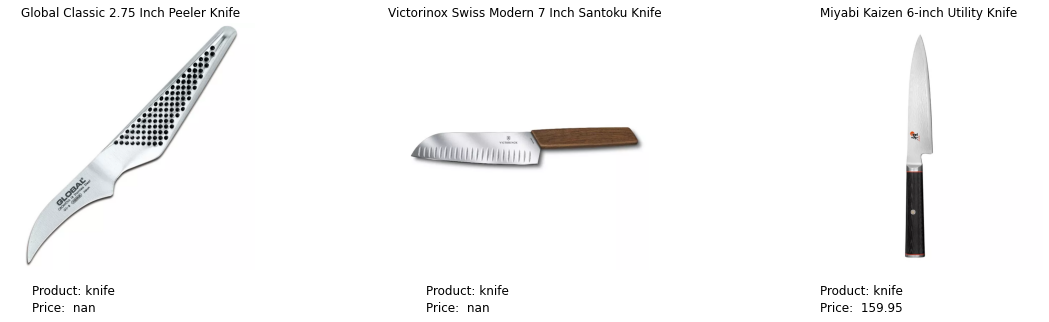

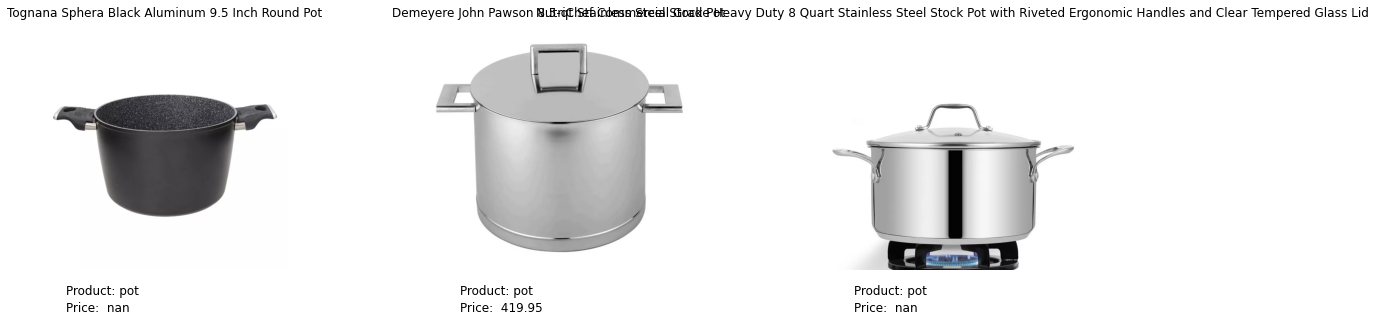

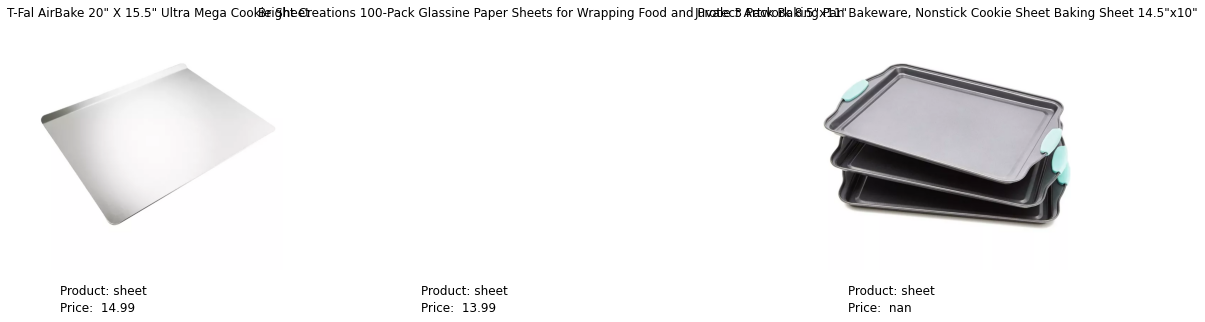

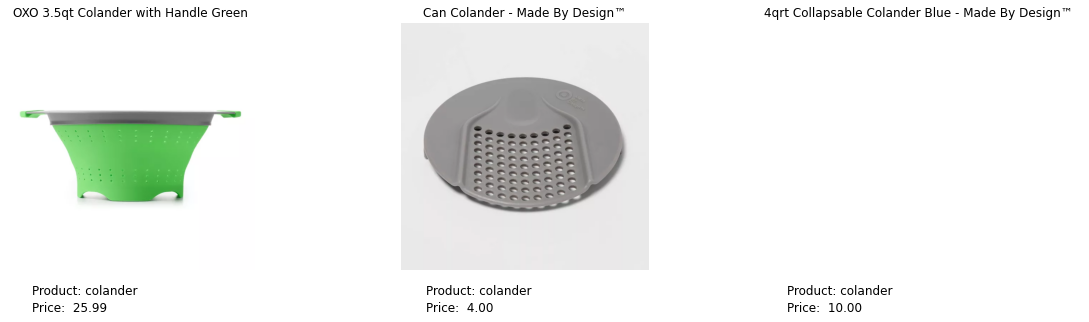

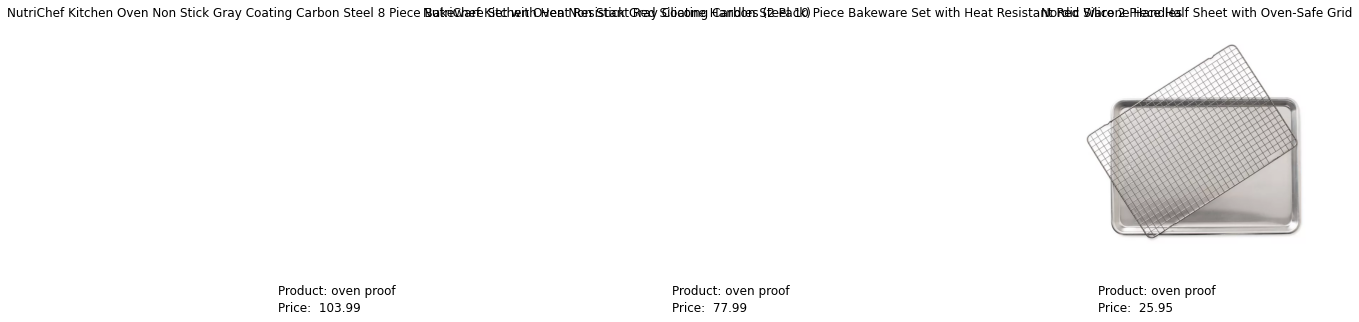

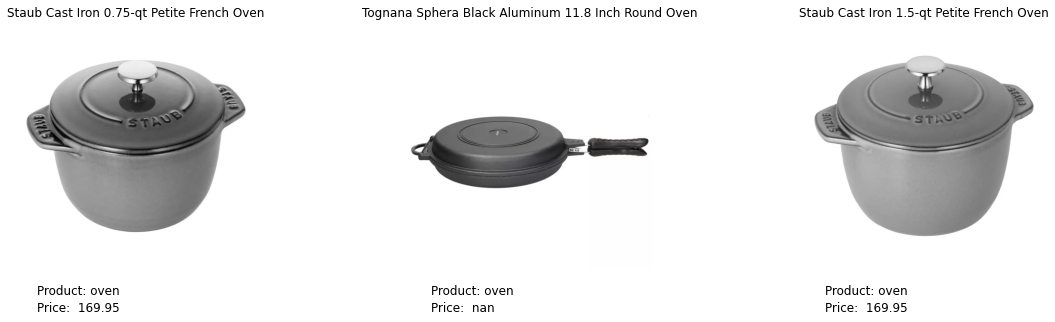

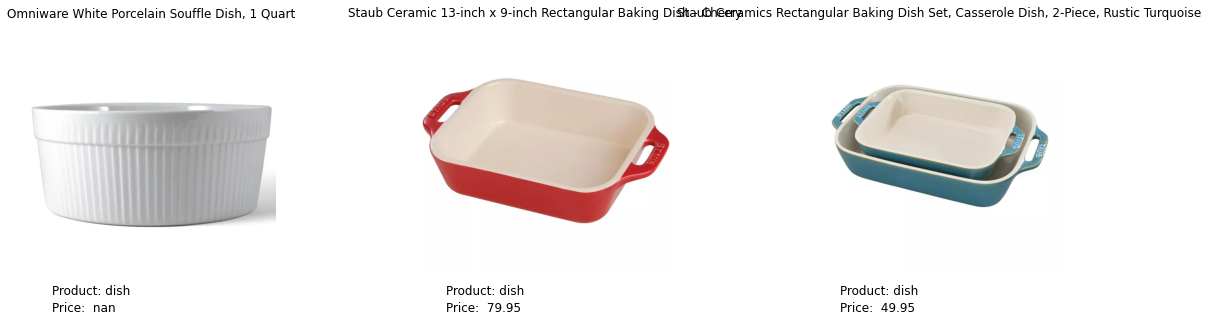

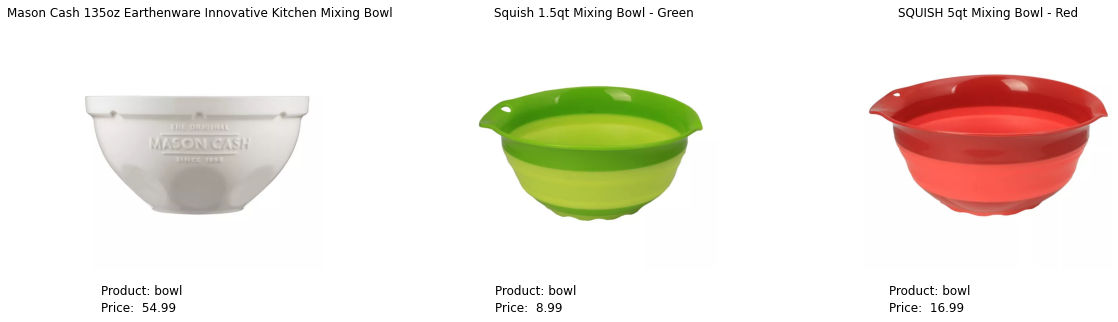

In [17]:
dp.display_products_df_kitchen_gadgets(display_df, 3)

In [ ]:
ner_model = spacy.blank('en')  # create blank Language class
print("Created blank 'en' model")

In [ ]:
TRAIN_DATA = [
    (x, {
        'entities': [(8, 28, 'TOOL'), (74, 89, 'METHOD')]
    })